## Batch Normalization

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
torch.manual_seed(0)

In [13]:
class Net(nn.Module):
    def __init__(self, dim_in, dim_H1, dim_H2, dim_out, act_func=nn.Sigmoid(), use_bn=True):
        super(Net, self).__init__()
        self.act_func = act_func
        self.use_bn = use_bn
        self.Linear1 = nn.Linear(dim_in, dim_H1)
        self.Linear2 = nn.Linear(dim_H1, dim_H2)
        self.Linear3 = nn.Linear(dim_H2, dim_out)
        
        self.bn1 = nn.BatchNorm1d(dim_H1) # Outputs of all but last linear layers
        self.bn2 = nn.BatchNorm1d(dim_H2)
        
    def forward(self, x):
        x = self.act_func(self.bn1(self.Linear1(x)) if self.use_bn else self.Linear1(x))
        x = self.act_func(self.bn2(self.Linear2(x)) if self.use_bn else self.Linear2(x))
        x = self.Linear3(x)
        return x

In [11]:
def train_model(model, criterion, trainloader, val_loader, optimizer, epochs):
    results_dict = {'training loss': [], 'val accuracy': []}
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y in trainloader:
            y_hat = model(x.view(-1, 28 * 28)) # MNIST
            loss = criterion(y_hat, y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        results_dict['training loss'].append(epoch_loss)
        
        correct = 0
        for x, y in val_loader:
            y_pred = model(x.view(-1, 28 * 28))
            _, label = torch.max(y_pred, 1)
            correct += (label==y).sum().item()
        results_dict['val accuracy'].append(correct / len(val_loader.dataset))
        print(epoch, end=' ')
    return results_dict

In [9]:
train_data = datasets.MNIST(root='../data', download=True, train=True, transform=transforms.ToTensor())
val_data = datasets.MNIST(root='../data', download=True, train=False, transform=transforms.ToTensor())

trainloader = DataLoader(train_data, batch_size=30)
val_loader = DataLoader(val_data, batch_size=len(val_data))

In [10]:
criterion = nn.CrossEntropyLoss()

In [14]:
model = Net(28 * 28, 100, 100, 10, use_bn=False)
optimizer = optim.SGD(model.parameters(), lr=0.1)
results = train_model(model, criterion, trainloader, val_loader, optimizer, 30)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [20]:
model_bn = Net(28 * 28, 100, 100, 10) # With batch normalization
optimizer = optim.SGD(model_bn.parameters(), lr=0.1)
results_bn = train_model(model_bn, criterion, trainloader, val_loader, optimizer, 30)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

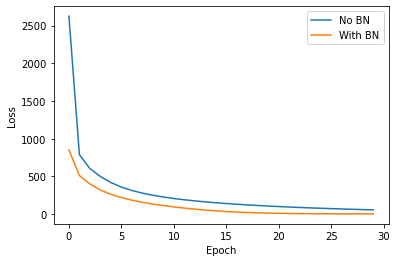

In [21]:
plt.plot(results['training loss'], label='No BN')
plt.plot(results_bn['training loss'], label='With BN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

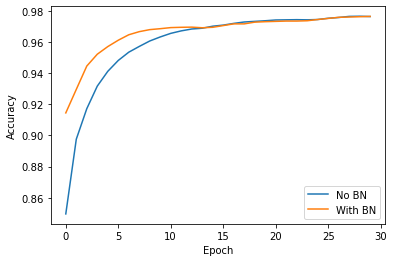

In [22]:
plt.plot(results['val accuracy'], label='No BN')
plt.plot(results_bn['val accuracy'], label='With BN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()